In [1]:
%load_ext ipydex.displaytools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# Source: https://cloudstor.aarnet.edu.au/plus/index.php/s/2DhnLGDdEECo4ys?path=%2FUNSW-NB15%20-%20CSV%20Files%2Fa%20part%20of%20training%20and%20testing%20set
data = pd.read_csv('./UNSW_NB15_training-set.csv')
data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [4]:
data.dtypes.value_counts()

int64      30
float64    11
object      4
dtype: int64

In [5]:
print( data['label'].value_counts(), '\n', data['proto'].value_counts(), '\n', 
      data['service'].value_counts(), '\n', data['state'].value_counts(), '\n\n', 
      data.isna().sum() )

1    45332
0    37000
Name: label, dtype: int64 
 tcp           43095
udp           29418
unas           3515
arp             987
ospf            676
              ...  
br-sat-mon       32
pvp              32
wsn              32
ib               31
igmp             30
Name: proto, Length: 131, dtype: int64 
 -           47153
dns         21367
http         8287
smtp         1851
ftp          1552
ftp-data     1396
pop3          423
ssh           204
ssl            30
snmp           29
dhcp           26
radius          9
irc             5
Name: service, dtype: int64 
 FIN    39339
INT    34163
CON     6982
REQ     1842
ACC        4
RST        1
CLO        1
Name: state, dtype: int64 

 id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload 

In [6]:
df = data.drop(['id'], axis=1)
#df = data.drop(['id','attack_cat'], axis=1)

#proto_ohe, service_ohe, state_ohe  = [OneHotEncoder()] *3
proto_ohe, service_ohe, state_ohe  = [LabelEncoder()] *3
attack_le = LabelEncoder()
df['proto'] = proto_ohe.fit_transform(df['proto'])
df['service'] = service_ohe.fit_transform(df['service'])
df['state'] = state_ohe.fit_transform(df['state'])
df['attack_cat'] = attack_le.fit_transform(df['attack_cat'])
#print( df['proto'].value_counts(), '\n', df['service'].value_counts(), '\n', df['state'].value_counts())

<AxesSubplot:title={'center':'Correlation with Malicious Label'}>

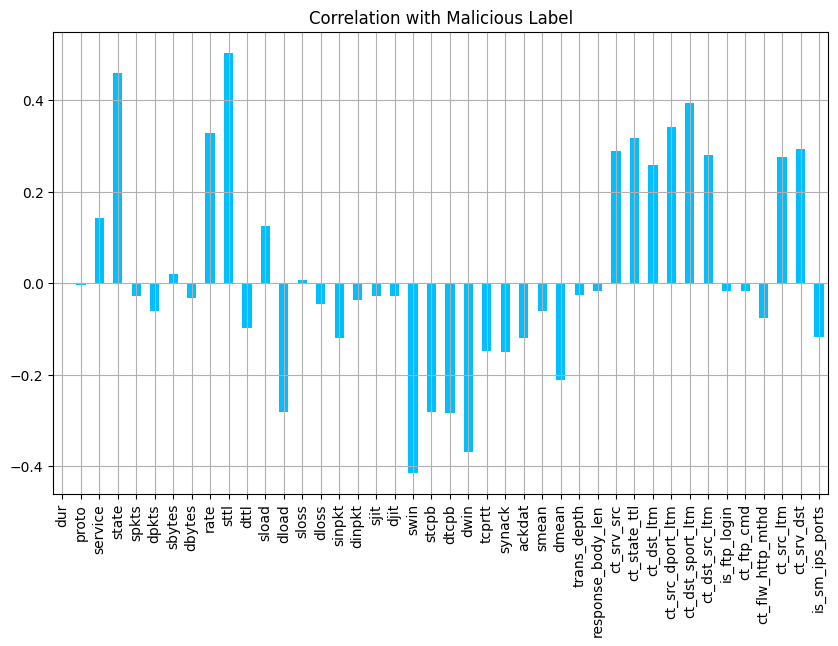

In [7]:
df.drop(['label','attack_cat'], axis=1).corrwith(df['label']).plot(kind='bar', grid=True, figsize=(10, 6), title="Correlation with Malicious Label",color="deepskyblue")

In [8]:
dm = df.drop(
    [k for k,v in  (df.drop(['label','attack_cat'], axis=1).corrwith(df['label']).abs().sort_values(ascending=True) < 0.2).items()  if v],
    axis=1)

dm.head()

,state,rate,sttl,dload,swin,stcpb,dtcpb,dwin,dmean,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,attack_cat,label
0,4,90909.0902,254,0.0,0,0,0,0,0,2,2,1,1,1,2,1,2,6,0
1,4,125000.0003,254,0.0,0,0,0,0,0,2,2,1,1,1,2,1,2,6,0
2,4,200000.0051,254,0.0,0,0,0,0,0,3,2,1,1,1,3,1,3,6,0
3,4,166666.6608,254,0.0,0,0,0,0,0,3,2,2,2,1,3,2,3,6,0
4,4,100000.0025,254,0.0,0,0,0,0,0,3,2,2,2,1,3,2,3,6,0


<AxesSubplot:>

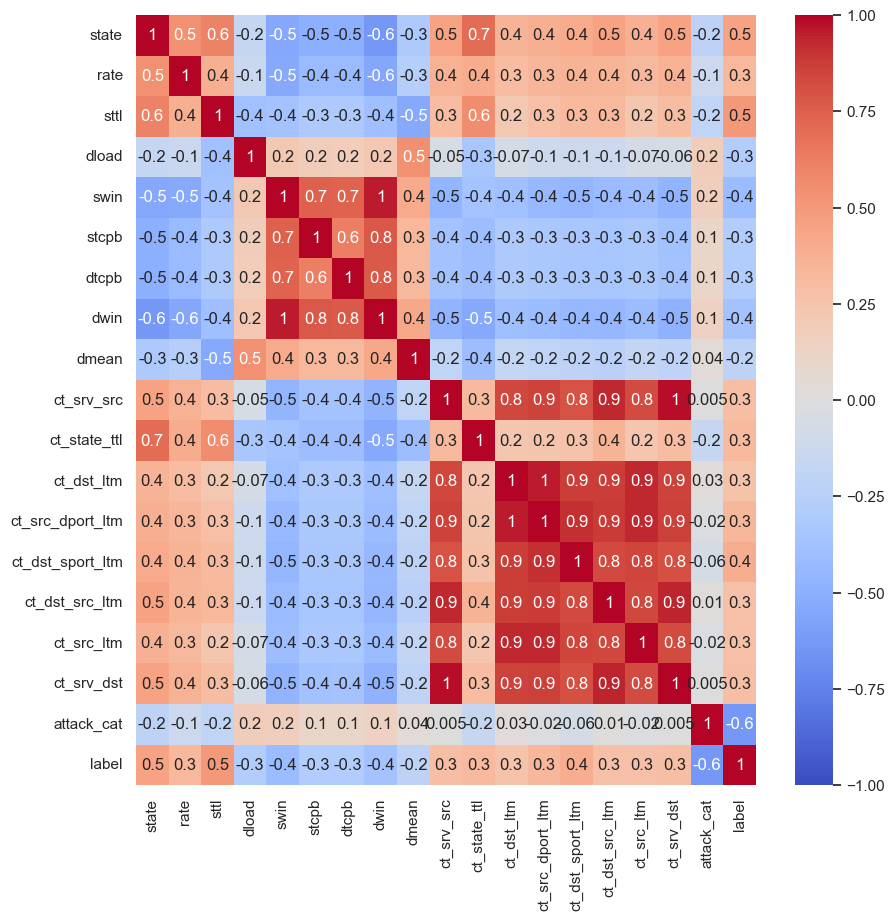

In [9]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(dm.corr(),vmin=-1, vmax=1, annot = True, fmt='.1g',cmap= 'coolwarm')

In [10]:
# Features to keep
#  'state',  'rate',  'sttl',  'swin',  'dload',  'dtcpb',  'dmean',  'ct_srv_src',  'ct_dst_ltm'
dn = dm.drop(['dwin', 'ct_srv_dst', 'ct_src_dport_ltm', 'ct_dst_ltm', 'ct_dst_src_ltm', 'ct_src_ltm','attack_cat'], axis=1)
dn.head()

,state,rate,sttl,dload,swin,stcpb,dtcpb,dmean,ct_srv_src,ct_state_ttl,ct_dst_sport_ltm,label
0,4,90909.0902,254,0.0,0,0,0,0,2,2,1,0
1,4,125000.0003,254,0.0,0,0,0,0,2,2,1,0
2,4,200000.0051,254,0.0,0,0,0,0,3,2,1,0
3,4,166666.6608,254,0.0,0,0,0,0,3,2,1,0
4,4,100000.0025,254,0.0,0,0,0,0,3,2,1,0


Dropping colinear results did not improve accuracy

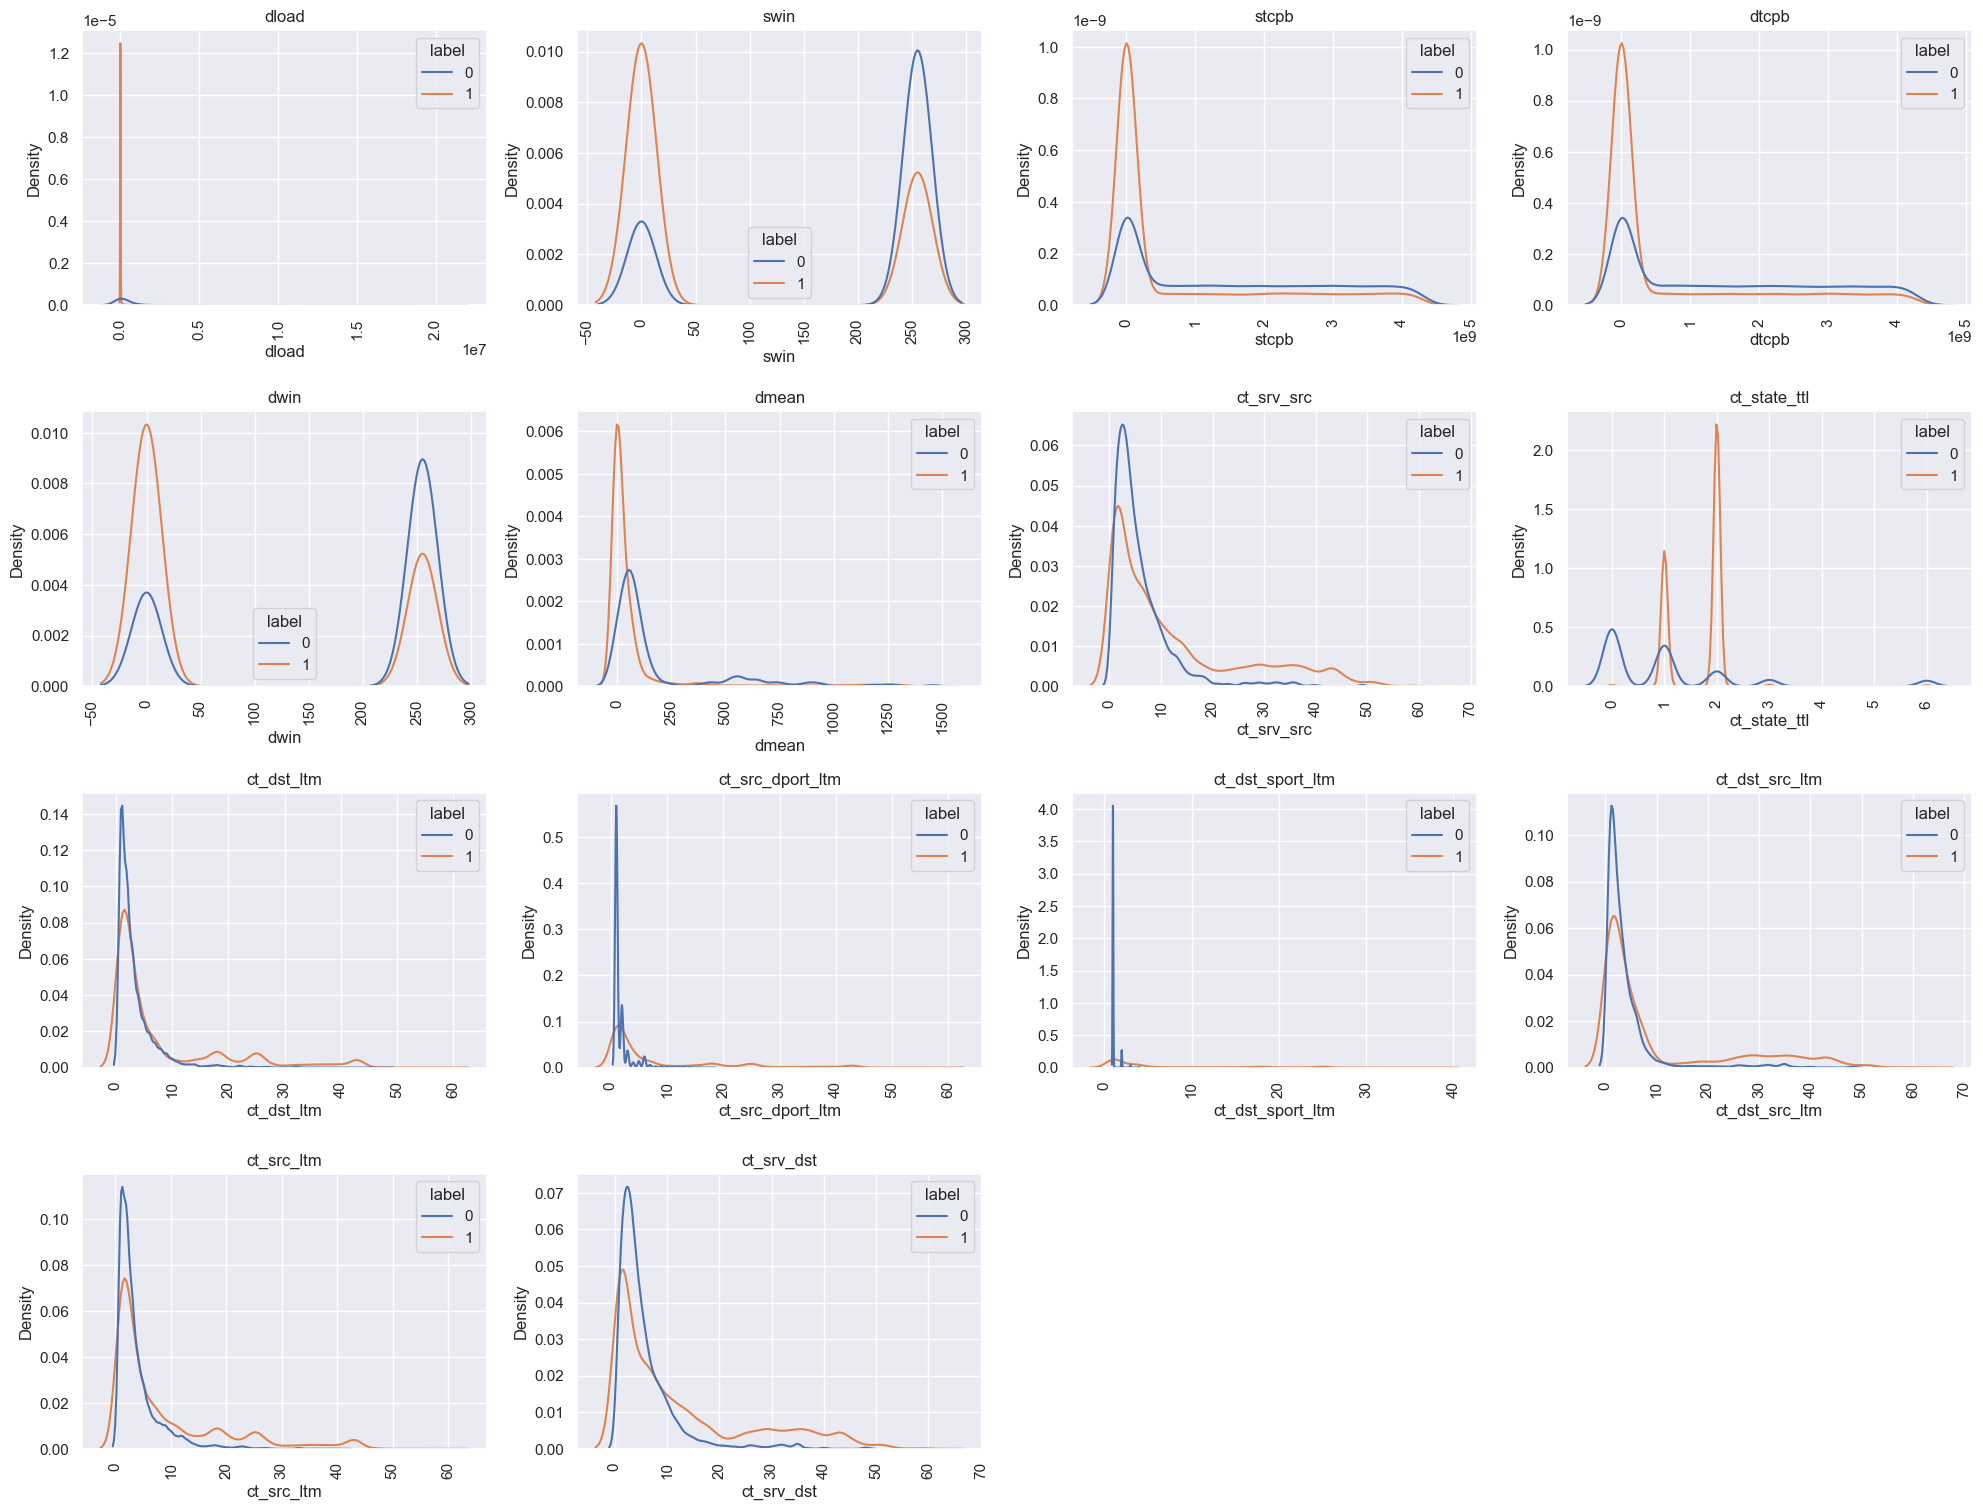

In [11]:
# All data columns except for color
feature_cols = [x for x in dm.columns if x not in ['label', 'state', 'rate', 'sttl','attack_cat']]
plt.figure(figsize=(20,30))
# loop for subplots
for i in range(len(feature_cols)):
    plt.subplot(8,4,i+1)
    plt.title(feature_cols[i])
    plt.xticks(rotation=90)
    sns.kdeplot(data=dm, x=feature_cols[i], hue='label')
    
plt.tight_layout()

In [12]:
#  scaler = StandardScaler()
#  mms = MinMaxScaler()

Scaler was net neutral and mms was a net negative.

In [13]:
pca = PCA(n_components=10).fit(df.drop('label', axis=1))
print(pca.explained_variance_ratio_)

[8.06262470e-01 1.86191575e-01 7.54452077e-03 1.41708538e-06
 7.59133488e-09 5.89829370e-09 3.38119953e-09 8.21330567e-10
 3.15828027e-10 9.56760169e-12]


In [14]:
pca = PCA(n_components=3).fit(df.drop(['label','attack_cat'], axis=1))
print(pca.explained_variance_ratio_)

pca = PCA(n_components=3).fit(dm.drop(['label','attack_cat'], axis=1))
print(pca.explained_variance_ratio_)

[0.80626247 0.18619157 0.00754452]
[8.12240206e-01 1.87758359e-01 1.43059819e-06]


In [11]:
#dm = PCA(n_components=3).fit(dm.drop('label', axis=1))
X_train, X_test, y_train, y_test = train_test_split(dm.drop(['label','attack_cat'], axis=1).to_numpy(), dm['label'], test_size=0.2)

PCA ended up giving worse results.

In [16]:
# defining parameter range
param_grid = {'n_neighbors': [1,3,5,7,9,11,13,15,17,19],  #odd numbers because there are 2 classes in target coulmn
              'weights': ['distance', 'uniform']}  
gridKNN = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
gridKNN.fit(X_train, y_train)
print(gridKNN.best_params_)
#predict with the best parameter
y_pred_test = gridKNN.predict(X_test)
y_pred_train = gridKNN.predict(X_train)

#Check accuracy and overfitting
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...n_neighbors=1, weights=distance;, score=0.812 total time=   2.6s
[CV 2/5] END ...n_neighbors=1, weights=distance;, score=0.813 total time=   2.5s
[CV 3/5] END ...n_neighbors=1, weights=distance;, score=0.814 total time=   2.8s
[CV 4/5] END ...n_neighbors=1, weights=distance;, score=0.812 total time=   2.5s
[CV 5/5] END ...n_neighbors=1, weights=distance;, score=0.815 total time=   2.5s
[CV 1/5] END ....n_neighbors=1, weights=uniform;, score=0.812 total time=   3.2s
[CV 2/5] END ....n_neighbors=1, weights=uniform;, score=0.813 total time=   3.5s
[CV 3/5] END ....n_neighbors=1, weights=uniform;, score=0.814 total time=   3.4s
[CV 4/5] END ....n_neighbors=1, weights=uniform;, score=0.812 total time=   3.3s
[CV 5/5] END ....n_neighbors=1, weights=uniform;, score=0.815 total time=   3.8s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.816 total time=   3.0s
[CV 2/5] END ...n_neighbors=3, weights=distance

In [22]:
# unsw_LDA = LinearDiscriminantAnalysis(n_components=1).fit_transform(dn.drop('label', axis=1), dn['label'])
# unsw_LDA_df = pd.DataFrame(data = unsw_LDA, columns = ["D 1"])
# unsw_LDA_df['label'] = dn['label']
# 
# sns.violinplot(data= unsw_LDA_df, x= unsw_LDA_df['D 1'],y= unsw_LDA_df['label'])


<AxesSubplot:title={'center':'Correlation with Attack Cat'}>

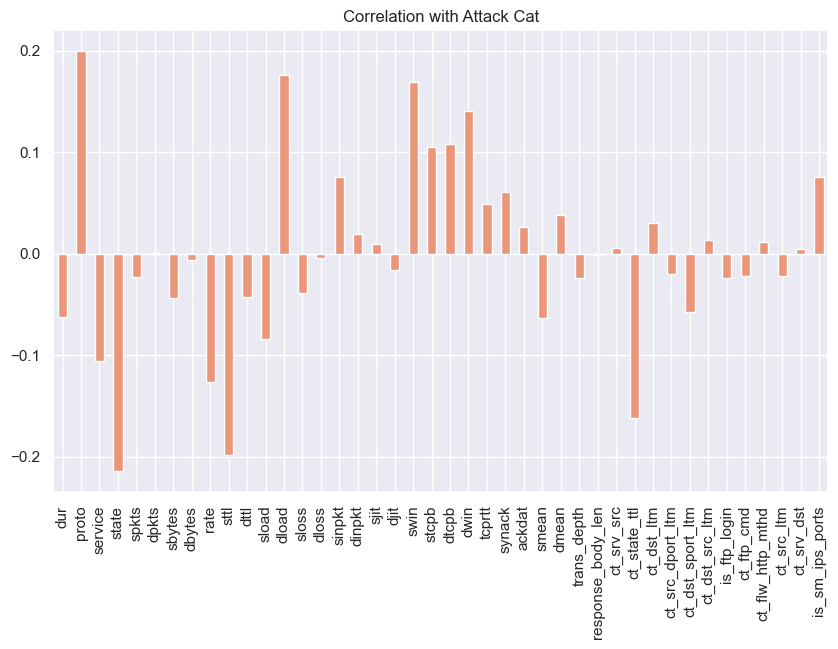

In [12]:
df.drop(['label','attack_cat'], axis=1).corrwith(df['attack_cat']).plot(kind='bar', grid=True, figsize=(10, 6), title="Correlation with Attack Cat",color="darksalmon")

In [13]:
da = df.drop(
    [k for k,v in  (df.drop(['label','attack_cat'], axis=1).corrwith(df['attack_cat']).abs().sort_values(ascending=True) < 0.05).items()  if v],
    axis=1)

da.head()

,dur,proto,service,state,rate,sttl,sload,dload,sinpkt,swin,stcpb,dtcpb,dwin,synack,smean,ct_state_ttl,ct_dst_sport_ltm,is_sm_ips_ports,attack_cat,label
0,0.000011,117,0,4,90909.0902,254,180363632.0,0.0,0.011,0,0,0,0,0.0,248,2,1,0,6,0
1,0.000008,117,0,4,125000.0003,254,881000000.0,0.0,0.008,0,0,0,0,0.0,881,2,1,0,6,0
2,0.000005,117,0,4,200000.0051,254,854400000.0,0.0,0.005,0,0,0,0,0.0,534,2,1,0,6,0
3,0.000006,117,0,4,166666.6608,254,600000000.0,0.0,0.006,0,0,0,0,0.0,450,2,1,0,6,0
4,0.000010,117,0,4,100000.0025,254,850400000.0,0.0,0.010,0,0,0,0,0.0,1063,2,1,0,6,0


<AxesSubplot:>

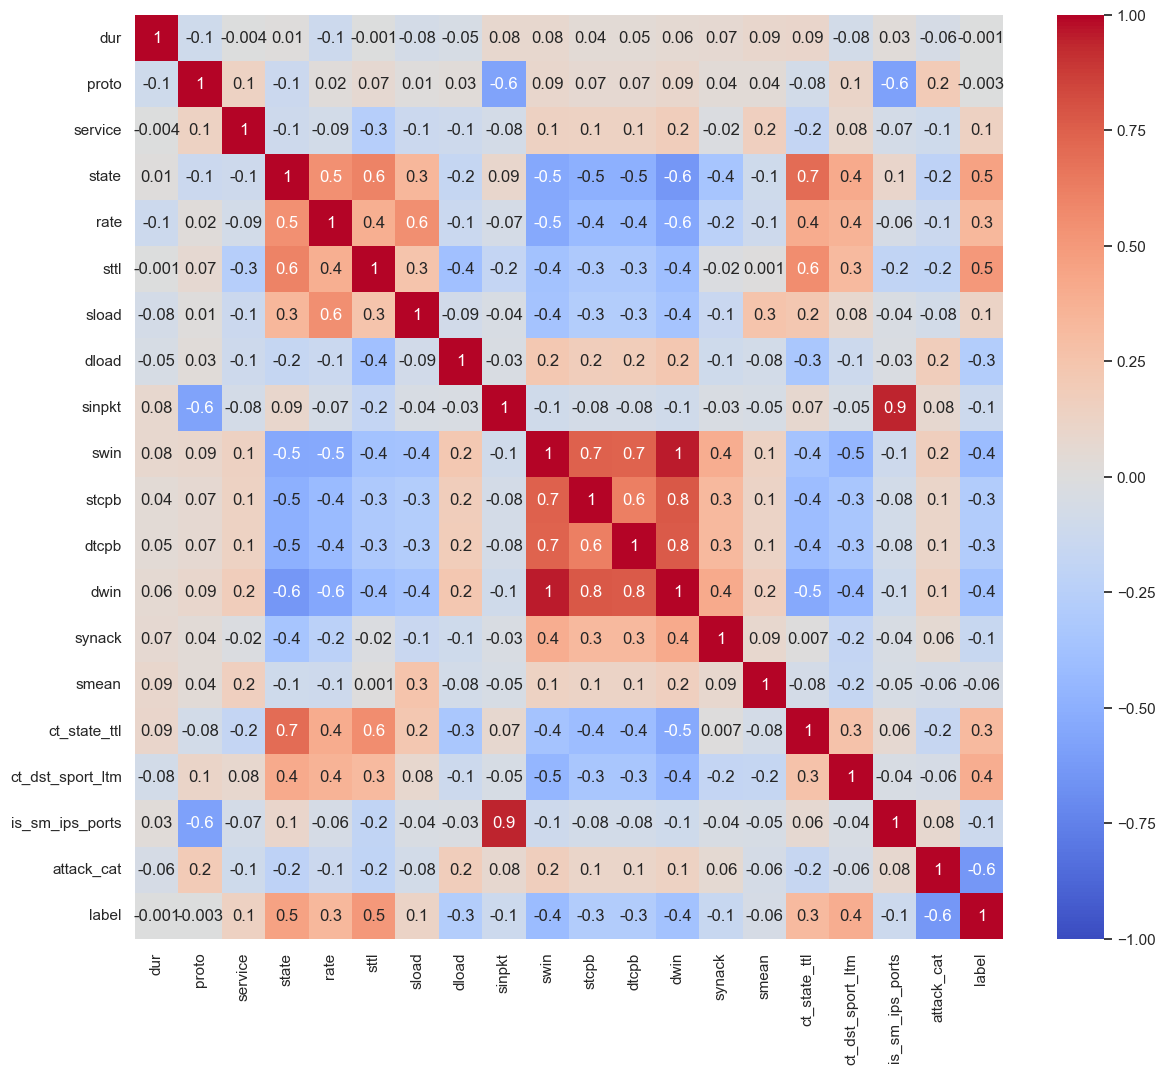

In [14]:
sns.set(rc = {'figure.figsize':(14,12)})
sns.heatmap(da.corr(),vmin=-1, vmax=1, annot = True, fmt='.1g',cmap= 'coolwarm')

/var/folders/8h/pt6dnpv520d200zx4xc71ld80000gn/T/ipykernel_6399/2220679263.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=da, x=feature_cols[i], hue='attack_cat', palette='colorblind')
/var/folders/8h/pt6dnpv520d200zx4xc71ld80000gn/T/ipykernel_6399/2220679263.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=da, x=feature_cols[i], hue='attack_cat', palette='colorblind')
/var/folders/8h/pt6dnpv520d200zx4xc71ld80000gn/T/ipykernel_6399/2220679263.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=da, x=feature_cols[i], hue='attack_cat', palette='colorblind')


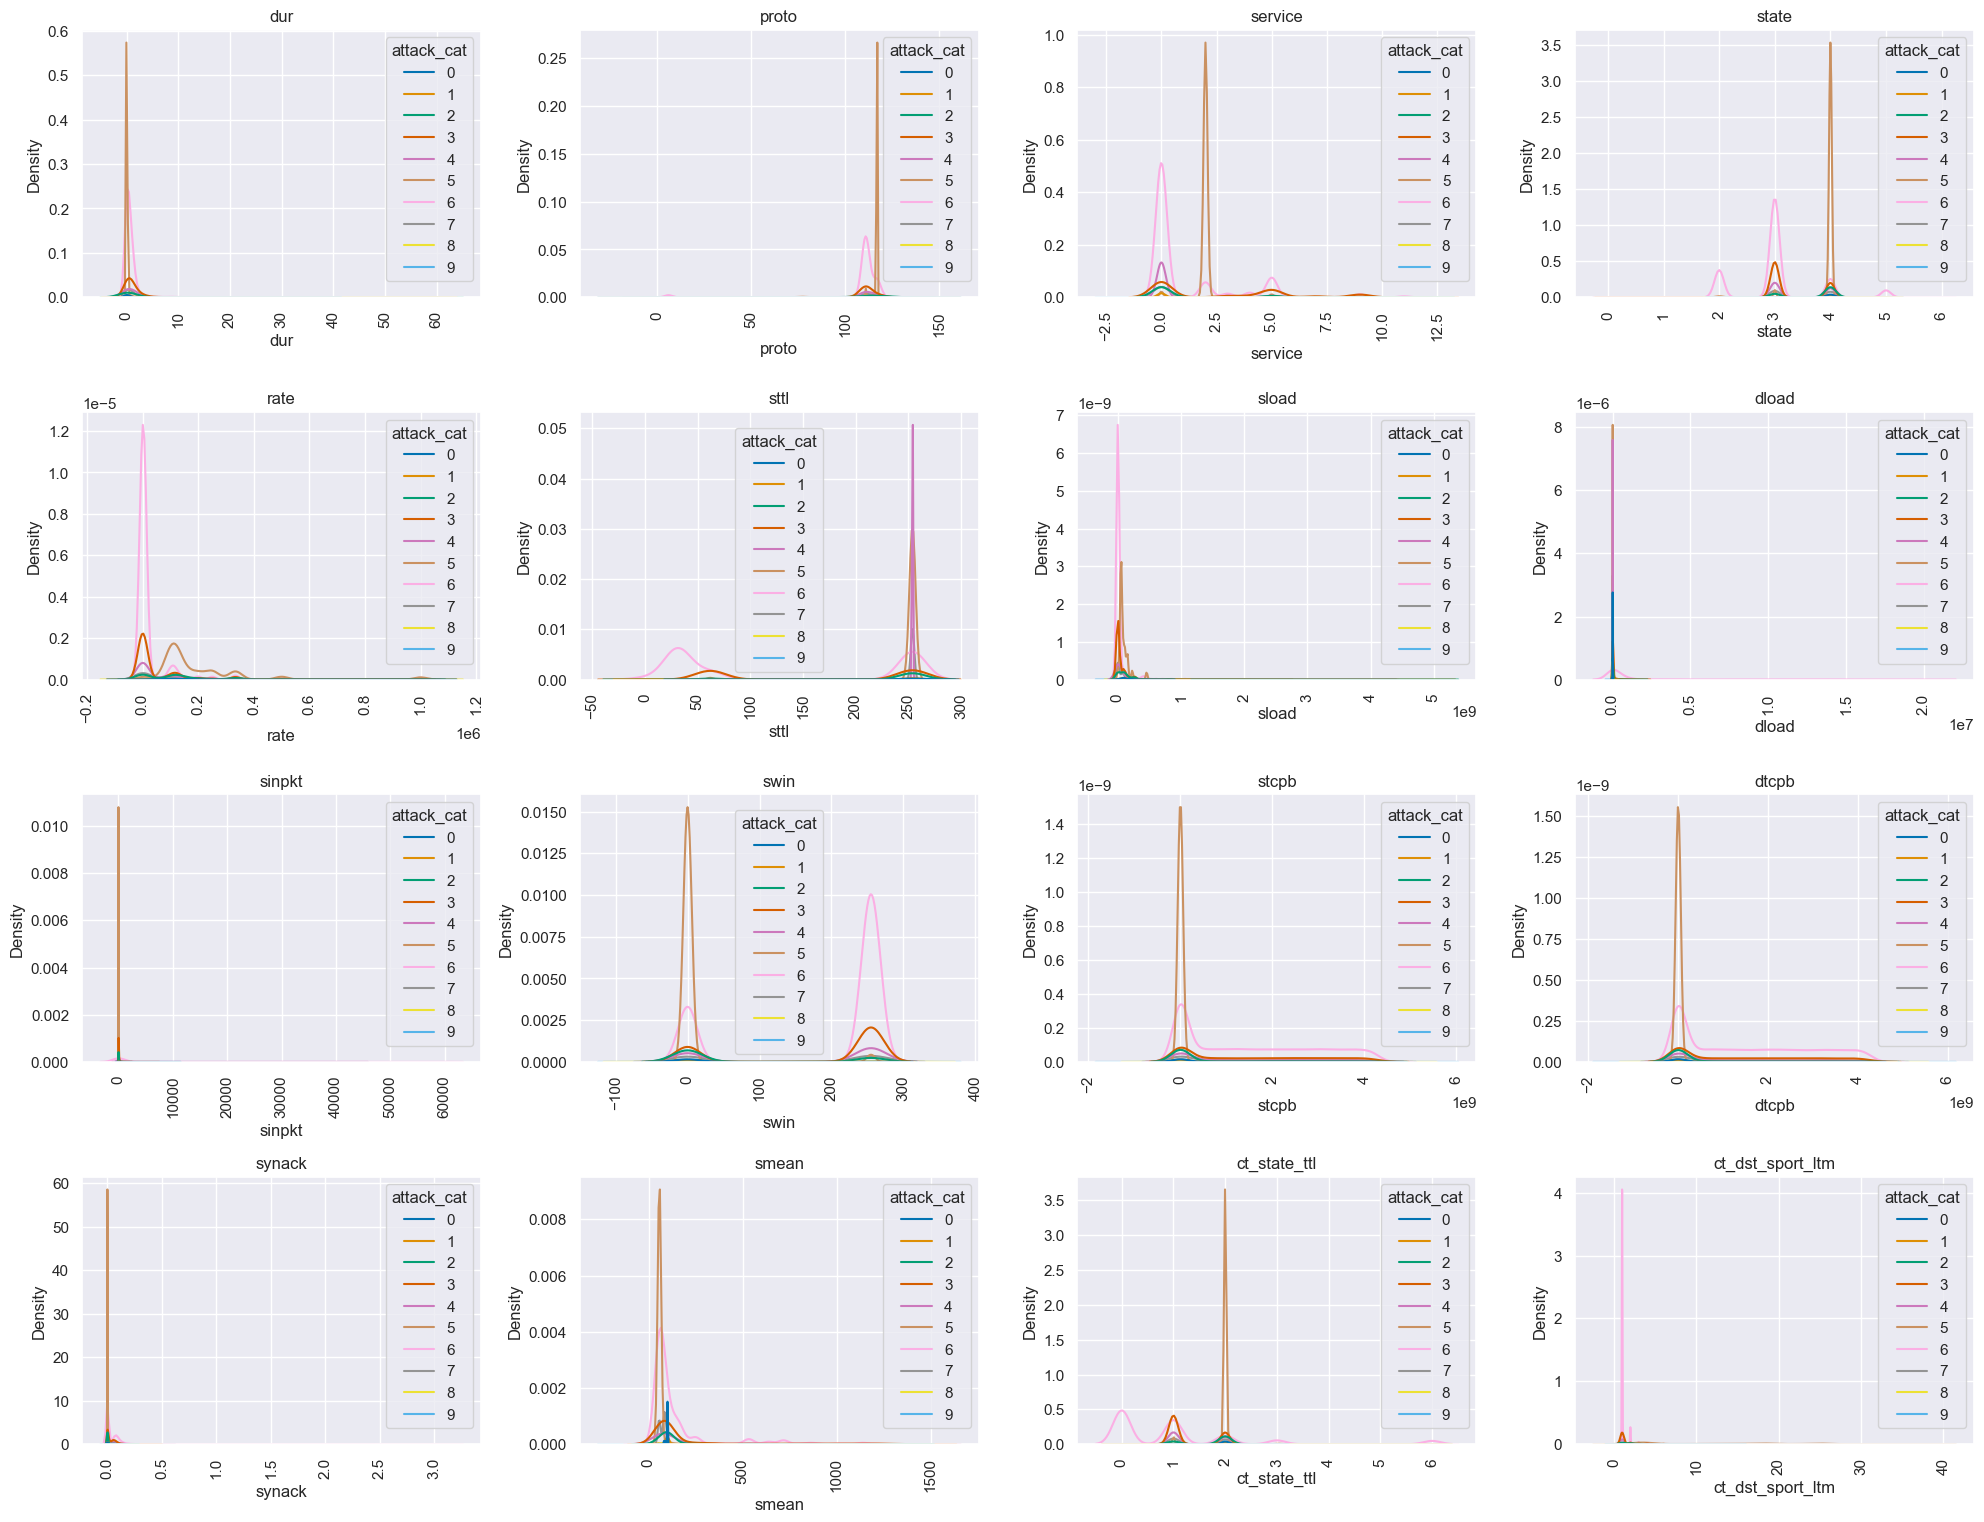

In [15]:
# All data columns except for color
feature_cols = [x for x in da.columns if x not in ['label', 'is_sm_ips_ports', 'dwin','attack_cat']]
plt.figure(figsize=(20,30))
# loop for subplots
for i in range(len(feature_cols)):
    plt.subplot(8,4,i+1)
    plt.title(feature_cols[i])
    plt.xticks(rotation=90)
    sns.kdeplot(data=da, x=feature_cols[i], hue='attack_cat', palette='colorblind')
    
plt.tight_layout()

In [16]:
da.attack_cat.value_counts()

6    37000
5    18871
3    11132
4     6062
2     4089
7     3496
0      677
1      583
8      378
9       44
Name: attack_cat, dtype: int64

In [17]:
from imblearn.over_sampling import BorderlineSMOTE

X, X_test, y, y_test = train_test_split(da.drop(['label','attack_cat'], axis=1).to_numpy(), da['attack_cat'], test_size=0.2)

X_train, y_train =  BorderlineSMOTE().fit_resample(X,y)

In [18]:
y_train.value_counts()

6    29648
3    29648
5    29648
4    29648
2    29648
7    29648
8    29648
1    29648
0    29648
9       36
Name: attack_cat, dtype: int64

In [24]:
# defining parameter range
param_grid = {'n_neighbors': [1,3,5,7,9,11,13,15,17,19],  #odd numbers because there are 2 classes in target coulmn
              'weights': ['distance', 'uniform']}  
gridKNN = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
gridKNN.fit(X_train, y_train)
print(gridKNN.best_params_)
#predict with the best parameter
y_pred_test = gridKNN.predict(X_test)
y_pred_train = gridKNN.predict(X_train)

#Check accuracy and overfitting
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...n_neighbors=1, weights=distance;, score=0.579 total time=  42.8s
[CV 2/5] END ...n_neighbors=1, weights=distance;, score=0.621 total time=  42.2s
[CV 3/5] END ...n_neighbors=1, weights=distance;, score=0.615 total time=  43.4s
[CV 4/5] END ...n_neighbors=1, weights=distance;, score=0.600 total time=  40.5s
[CV 5/5] END ...n_neighbors=1, weights=distance;, score=0.607 total time=  39.8s
[CV 1/5] END ....n_neighbors=1, weights=uniform;, score=0.579 total time=  42.2s
[CV 2/5] END ....n_neighbors=1, weights=uniform;, score=0.621 total time=  41.4s
[CV 3/5] END ....n_neighbors=1, weights=uniform;, score=0.615 total time=  41.3s
[CV 4/5] END ....n_neighbors=1, weights=uniform;, score=0.600 total time=  41.3s
[CV 5/5] END ....n_neighbors=1, weights=uniform;, score=0.607 total time=  45.1s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.593 total time=  44.4s
[CV 2/5] END ...n_neighbors=3, weights=distance

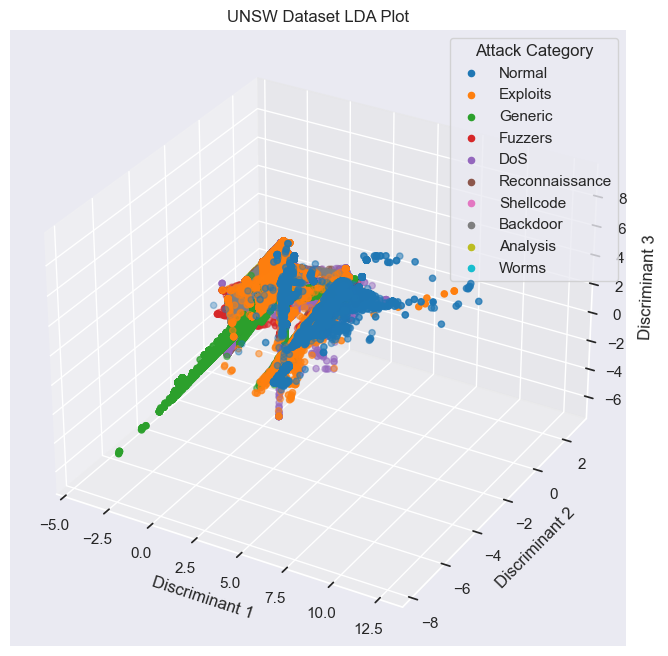

In [23]:
unsw_LDA = LinearDiscriminantAnalysis(n_components=3).fit_transform(da.drop('attack_cat', axis=1), da['attack_cat'])
unsw_LDA_df = pd.DataFrame(data = unsw_LDA, columns = ["D 1", "D 2", "D 3"])
unsw_LDA_df['attack_cat'] = attack_le.inverse_transform(da['attack_cat'])
unsw_LDA_df.head()

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection = '3d')

unique_cats = unsw_LDA_df['attack_cat'].unique()
colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(unique_cats)))
color_dict = dict(zip(unique_cats, colors))

for cat in unique_cats:
    df_subset = unsw_LDA_df[unsw_LDA_df['attack_cat'] == cat]
    ax.scatter(df_subset['D 1'], df_subset['D 2'], df_subset['D 3'], color = color_dict[cat], label = cat)

ax.set_xlabel("Discriminant 1")
ax.set_ylabel("Discriminant 2")
ax.set_zlabel("Discriminant 3")

plt.legend(title = "Attack Category")
plt.title("UNSW Dataset LDA Plot")

#ax.view_init(elev=25, azim=180)
#ax.view_init(elev=20, azim=160)
plt.show()